# Partialling for Bayesian profit

In [1]:
import pytensor
import matplotlib.pyplot as plt
import numpy as np

In [2]:
try:
    import pymc
except Exception as exc:
    print(exc)
else:
    print("You still don't need PyMC!")

No module named 'pymc'


## Fancy ~~PyMC~~ ugh PyTensor Bayesian model

In [3]:
import pytensor.tensor as pt
import pytensor.tensor.random as ptr
from pytensor.graph import rewrite_graph

x_data = pt.vector("x_data")
y_data = pt.vector("y_data")

X = pt.stack([pt.ones_like(x_data), x_data, x_data ** 2, x_data ** 3], axis=-1)

weights = ptr.normal(size=(4,), name="weights")
loc = pt.dot(X, weights)
noise = 0.008
y = ptr.normal(loc, noise, name="y")

## ~~Graphviz~~ Textviz

In [4]:
rewrite_graph(y).dprint()

normal_rv{"(),()->()"}.1 [id A] 'y'
 ├─ RNG(<Generator(PCG64) at 0x7F316F34EDC0>) [id B]
 ├─ NoneConst{None} [id C]
 ├─ dot [id D]
 │  ├─ Join [id E]
 │  │  ├─ 1 [id F]
 │  │  ├─ Second [id G]
 │  │  │  ├─ ExpandDims{axis=1} [id H]
 │  │  │  │  └─ x_data [id I]
 │  │  │  └─ [[1.]] [id J]
 │  │  ├─ ExpandDims{axis=1} [id H]
 │  │  │  └─ ···
 │  │  ├─ Pow [id K]
 │  │  │  ├─ ExpandDims{axis=1} [id H]
 │  │  │  │  └─ ···
 │  │  │  └─ [[2]] [id L]
 │  │  └─ Pow [id M]
 │  │     ├─ ExpandDims{axis=1} [id H]
 │  │     │  └─ ···
 │  │     └─ [[3]] [id N]
 │  └─ normal_rv{"(),()->()"}.1 [id O] 'weights'
 │     ├─ RNG(<Generator(PCG64) at 0x7F316F34D0E0>) [id P]
 │     ├─ [4] [id Q]
 │     ├─ [0.] [id R]
 │     └─ [1.] [id S]
 └─ [0.008] [id T]


## Prior sampling

[-0.09448203 -0.21833171  0.09605592  0.650308  ]


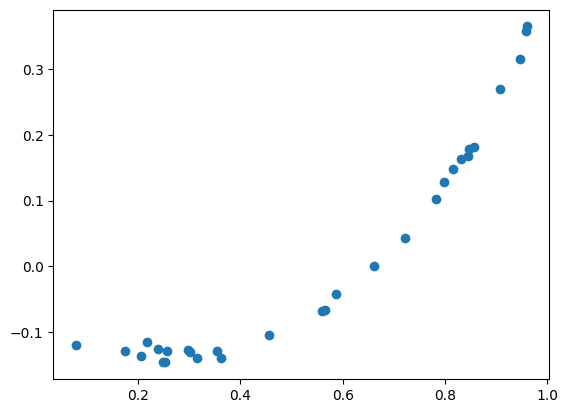

In [5]:
from pytensor.graph.replace import graph_replace

updates = {
    weights.owner.inputs[0]: weights.owner.outputs[0],
    y.owner.inputs[0]: y.owner.outputs[0]
}

prior_fn = pytensor.function([x_data], [weights, y], updates=updates)

x_whatever = pt.random.uniform(size=(30,)).eval()
weights_prior, y_prior = prior_fn(x_whatever)
print(weights_prior)
plt.scatter(x_whatever, y_prior)

### Controlling variates for fake data simulation

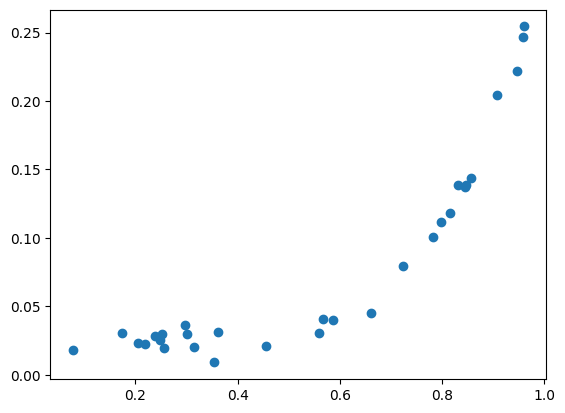

In [6]:
set_weights = np.array([0, 0.3, -1, 1])

updates = {y.owner.inputs[0]: y.owner.outputs[0]}
y_partial_fn = pytensor.function([x_data, weights], y, updates=updates)
y_fake = y_partial_fn(x_whatever, set_weights)
plt.scatter(x_whatever, y_fake)

## Posterior sampling

In [7]:
from pytensor.graph import ancestors, Constant
from pytensor.tensor.elemwise import DimShuffle
from pytensor.tensor.math import Dot
from pytensor.tensor.random.basic import NormalRV

def sample_posterior(
    unobserved_rvs,
    observed_rvs,
    data: dict,
    tune: int,
    draws: int,
    chains: int,
):

    if not (len(unobserved_rvs) == 1 and len(observed_rvs) == 1 and len(data) == 2):
        raise NotImplementedError(
            f"Posterior sampling of model with {len(unobserved_rvs)=}, {len(observed_rvs)=} and {len(data)=} not implemented")
    
    [w] = unobserved_rvs
    [y] = observed_rvs
    if not isinstance(y.owner.op, NormalRV):
        raise NotImplementedError(f"Posterior sampling of model with {y.owner.op} observed variate not implemented")
    if not isinstance(w.owner.op, NormalRV):
        raise NotImplementedError(f"Posterior sampling of model with {w.owner.op} unobserved variate not implemented")
    y_loc, y_scale = y.owner.op.dist_params(y.owner)

    if not (
        isinstance(y_scale, Constant) 
        or (
            isinstance(y_scale.owner.op, DimShuffle) 
            and isinstance(y_scale.owner.inputs[0], Constant)
        )
    ):
        raise NotImplementedError(f"Posterior sampling of model with non-constant noise for observed variate not implemented")

    # Find whith one is w, and which one is Phi
    if not isinstance(y_loc.owner.op, Dot):
        raise NotImplementedError(f"Posterior sampling for model with observed mean {y_loc.owner.op} not implemented")
    a, b = y_loc.owner.inputs
    
    if a is w:
        Phi = b
    elif b is w:
        Phi = a
    else:
        raise NotImplementedError(
            "Posterior sampling where unobserved variate is not used in the dot product "
            "that defines the mean of the observed variate not implemented."
        )
    w_loc, w_scale = w.owner.op.dist_params(w.owner)        

    # Find which one is x and which one is y
    Phi_ancestors = set(ancestors([Phi]))
    (x, x_data), (y, y_data) = data.items()
    if not x in Phi_ancestors and y not in Phi_ancestors:
        (y, y_data), (x, x_desta) = data.items()    
        if not x in Phi_ancestors and y not in Phi_ancestors:
            raise NotImplementedError(
                "Posterior sampling for a model where both or none of the data variables show up "
                "in the deterministic componenent of the dot product that defines the mean of the "
                "observed variate not implemented."
            )
            
    posterior_cov = y_scale ** 2 * pt.linalg.inv(y_scale ** 2 * w_scale + Phi.T @ Phi)
    posterior_mean = posterior_cov @ (w_scale * w_loc + Phi.T @ y / y_scale ** 2)
    posterior_w = pt.random.multivariate_normal(posterior_mean, posterior_cov, size=(chains, tune + draws))

    return posterior_w.eval({x: x_data, y: y_data})[:, tune:]

In [8]:
posterior_weights = sample_posterior(
    unobserved_rvs=[weights], 
    observed_rvs=[y],
    data={x_data: x_whatever, y_data: y_fake},
    tune=0,  # Library has fantastic tuning, no need for anything >0
    chains=1,  # Good mixing is guaranteed by this library, no need for multiple chains
    draws=100,  # Pretty good ESS from this library, no need for more
)

### Checking diagnostics out of habit

In [9]:
import arviz as az

In [10]:
az.summary(posterior_weights)

arviz - WARNING - Shape validation failed: input_shape: (1, 100), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x[0],0.001,0.012,-0.018,0.023,0.001,0.001,150.0,117.0,NaN
x[1],0.278,0.081,0.121,0.423,0.006,0.004,173.0,112.0,NaN
x[2],-0.931,0.164,-1.219,-0.606,0.012,0.009,167.0,112.0,NaN
x[3],0.947,0.101,0.772,1.153,0.007,0.006,177.0,99.0,NaN


array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'x'}>]],
      dtype=object)

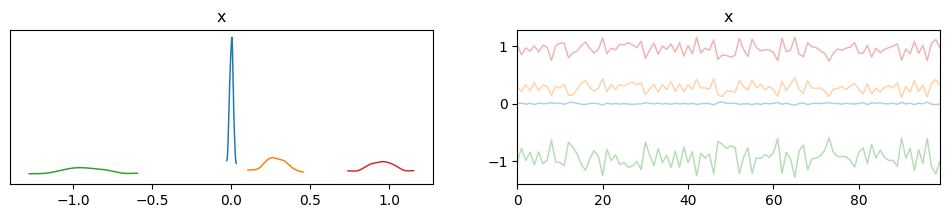

In [11]:
az.plot_trace(posterior_weights)

array([<Axes: title={'center': 'x\n0'}>, <Axes: title={'center': 'x\n1'}>,
       <Axes: title={'center': 'x\n2'}>, <Axes: title={'center': 'x\n3'}>],
      dtype=object)

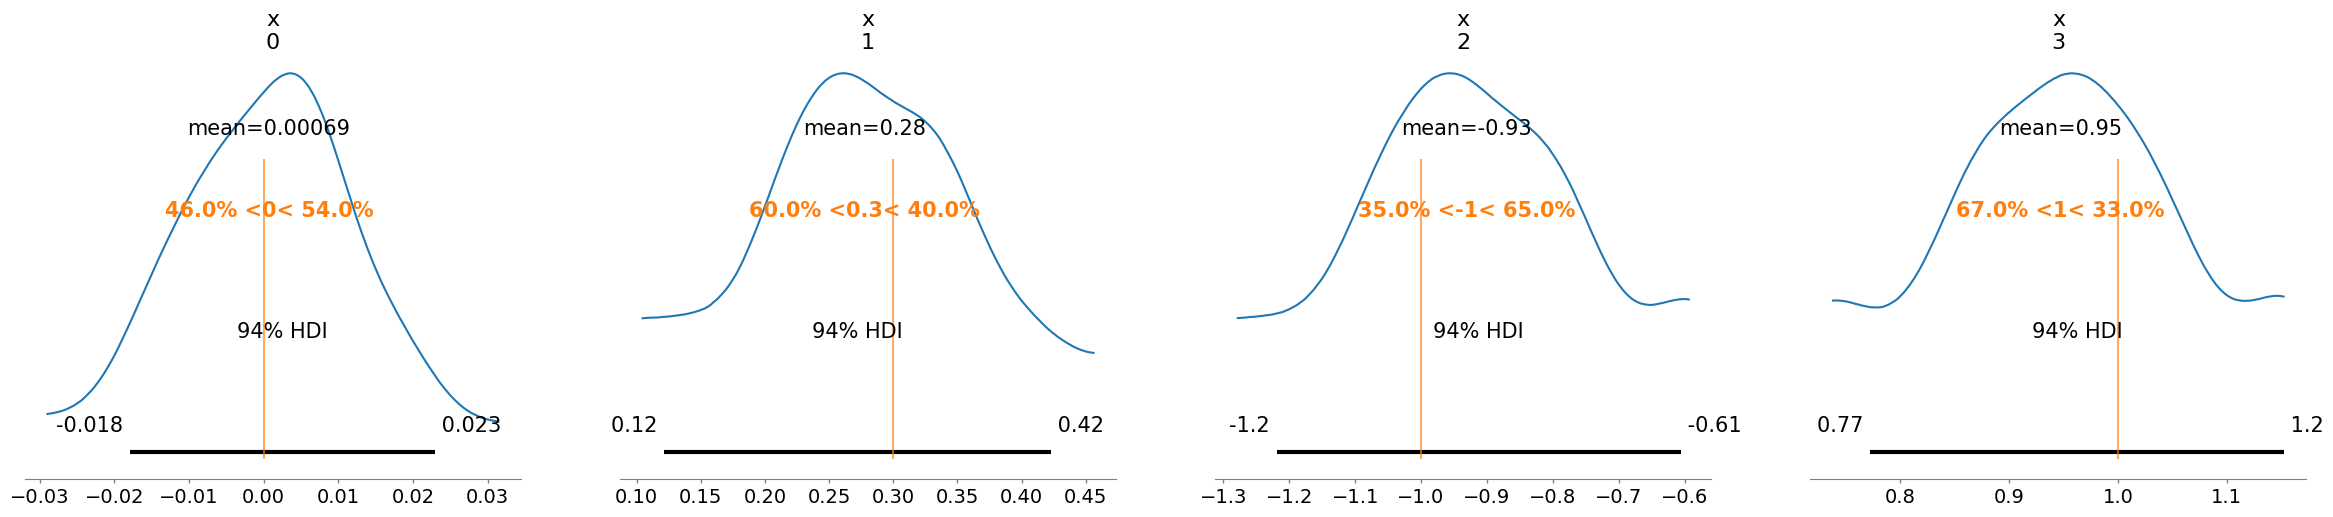

In [12]:
az.plot_posterior(posterior_weights, ref_val=[0, 0.3, -1, 1])

## Optimization

Now for the fun-part, once we have posterior samples, how can we use the original model for optimization?

Let's say we are an adverstising firm, and x is our unlimited budget to spend on a TV ads, while y is dropout rate from the service we want to convince people to stick to. We want to minimize y.

In [13]:
from pytensor.graph import rewrite_graph
from pytensor.graph.replace import vectorize_graph

In [14]:
loc_one_day = loc[0]  # Restrict prediction to one single datapoint
loc_posterior = vectorize_graph(loc_one_day, replace={weights: pt.as_tensor(posterior_weights)})
# loc_posterior.dprint(print_shape=True)

In [15]:
loss = loc_posterior.mean()
loss_grad = pt.grad(loss, wrt=x_data)
loss_fn = pytensor.function([x_data], [loss, loss_grad])
# loss_fn.dprint()

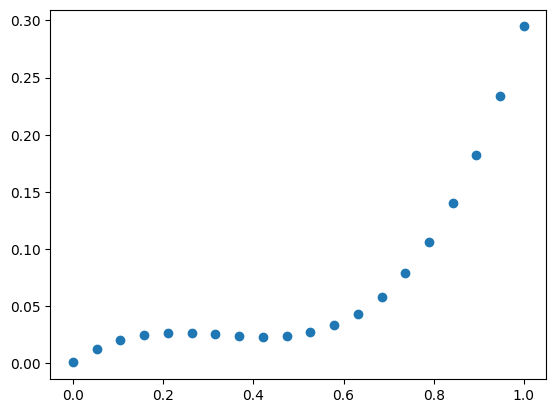

In [16]:
x_options = pt.linspace(0, 1, 20).eval()
plt.scatter(
    x_options,
    [loss_fn([x_opt])[0] for x_opt in x_options]
)

In [17]:
from scipy.optimize import minimize

res = minimize(
    loss_fn,
    jac=True,
    x0 = [0.2],
    bounds = [(0, 1)],
)
res

  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 0.0006927278029087392
        x: [ 0.000e+00]
      nit: 2
      jac: [ 2.777e-01]
     nfev: 5
     njev: 5
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

In [18]:
res.x

array([0.])

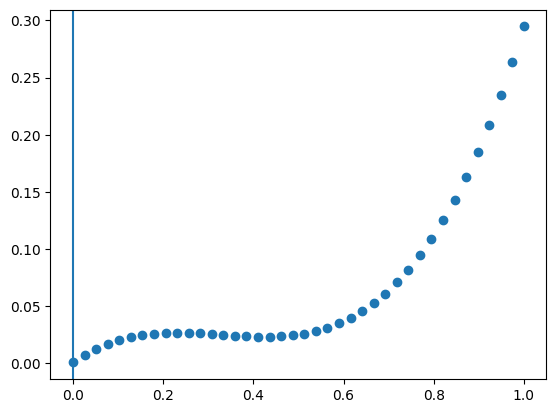

In [19]:
x_options = pt.linspace(0, 1, 40).eval()
plt.scatter(
    x_options,
    [loss_fn([x_opt])[0] for x_opt in x_options]
)
plt.axvline(res.x);

### Nudging the results

Uh-Oh as we knew all along internally, advertising has a negative net-effect. As an advertising firm, we can't really tell our client not to spend any money on TV ads, or we'll lose our livelihoods. Let's add a "regularizing" constraint

In [20]:
res = minimize(
    loss_fn,
    jac=True,
    x0 = [0.7],
    bounds=[(0.3, 1)],
)
res

  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 0.023260962194951374
        x: [ 4.257e-01]
      nit: 6
      jac: [-5.685e-06]
     nfev: 8
     njev: 8
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

In [21]:
res.x

array([0.42565393])

We should spend 42% of the budget

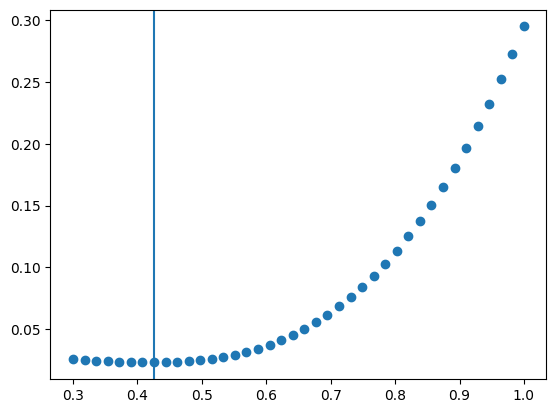

In [22]:
x_options = pt.linspace(0.3, 1, 40).eval()
plt.scatter(
    x_options,
    [loss_fn([x_opt])[0] for x_opt in x_options]
)
plt.axvline(res.x);

## Posterior predictive sampling

In [23]:
y_pred = vectorize_graph(y, replace={weights: pt.as_tensor(posterior_weights)})
updates = {y_pred.owner.inputs[0]: y_pred.owner.outputs[0]}
y_pred_fn = pytensor.function([x_data], y_pred[0, :, 0], updates=updates)

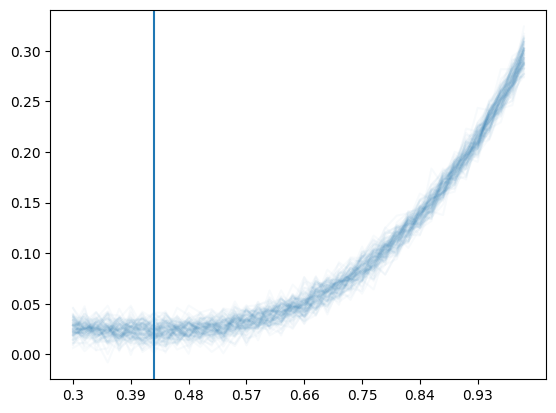

In [24]:
x_options = pt.linspace(0.3, 1, 40).eval()
plt.plot(np.array([y_pred_fn([x_opt]) for x_opt in x_options]), color="C0", alpha=0.03);
plt.axvline(np.argmin((x_options - res.x) ** 2))
plt.xticks(np.arange(40)[::5], np.round(x_options[::5], 2));